Importation des librairies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

Téléchargement du jeu de données 

In [2]:
data = pd.read_csv("stars_train.csv")
X_test = pd.read_csv("stars_test.csv")

#On sépare les covariables et variable à prédire 
X = data[data.columns[0:-1]]
y = data[["label"]]

In [3]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.33, random_state=42)

In [4]:
g= sns.pairplot(data,hue = 'label', diag_kind= 'hist',vars=data.columns,plot_kws=dict(alpha=0.5), diag_kws=dict(alpha=0.5))
plt.show()

KeyboardInterrupt: 

On remarque que les catégories sont déséquilibrées, en effet on a beaucoup plus d'effectifs de la catégorie 

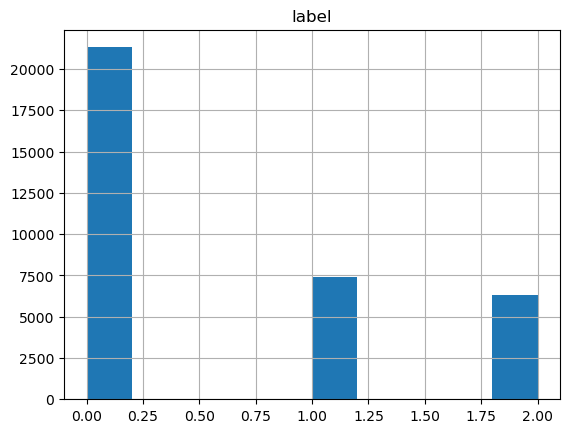

In [4]:
y_tr.hist()
plt.show()

On peut egalement apprécier une claire défintion des labels sur la variable redshift

In [5]:
from sklearn.metrics import f1_score

def train_eval(model, X, y, X_test, y_test):
    lab = str(model()) 
    #Entrainement du modèle 
    mod = model()
    mod.fit(X,y)
    pred = mod.predict(X_test)

    plt.figure()
    plt.hist(y_te, density=True, label="True", alpha=0.5)
    plt.hist(pred, density=True, label=lab, alpha=0.5)
    plt.title("Histogramme des predicitions de "+lab)
    plt.legend()
    plt.show()

    print("f1_score: ", f1_score(y_test, pred, average='weighted'))
    return pred 

Regression logistique

/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


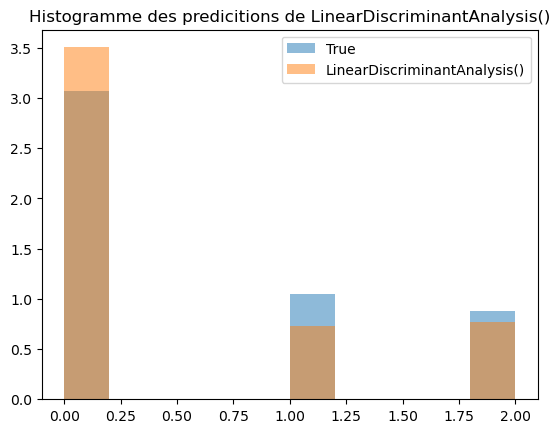

f1_score:  0.8391509408398584


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import r2_score


pred_lr = train_eval(LinearDiscriminantAnalysis, X_tr, y_tr, X_te, y_te)

On constate que le modèle produit des résultats assez bons, cepedant il prédit moins d'effectifs dans les classes 1 et 2 de ce qu'il y a pour de vrai et plus d'effectifs dans la classe à plus grand effectif.
 
On pourrait, commme dans le problème de régréssion, essayer de créer des effectifs artificiels qui équilibreraient le dataset. 

In [7]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=0, sampling_strategy='all')
X_, y_ =oversample.fit_resample(X,y)
Xtr, Xte, ytr, yte = train_test_split(X_, y_, test_size=0.33, random_state=42)

/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


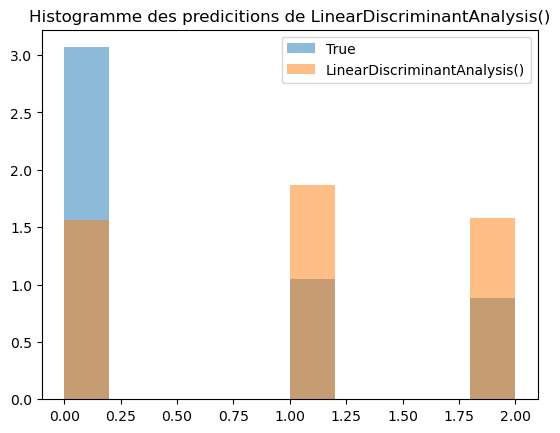

f1_score:  0.8072064260149521


In [8]:
pred_lda = pred_lr = train_eval(LinearDiscriminantAnalysis, Xtr, ytr, Xte, yte)

On remarque que cette solution n'améliore pas énormement la qualité des prédictions (+0.01 du r2_score). 
En effet, on a l'imprésion que la quantité d'effectifs peut être un paramètre important dans cette prédiction. On continuera ainsi avec le dataset non ré-équilibré. 

Comme deuxième tentative, on peut essayer d'utiliser les remarques du plot g. En effet, on remarque que la variable redshift contre alpha/delta permet de définir une claire frontière entre les trois classes. On peut envisager de calculer les valeurs (1-D) qui permettent de faire cette division sur la variable redshift. 

<Axes: xlabel='alpha', ylabel='redshift'>

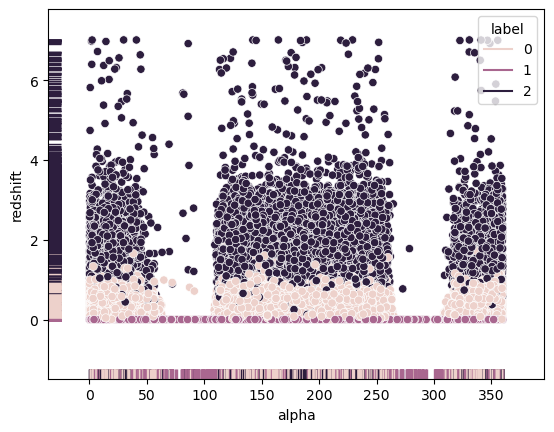

In [13]:
sns.scatterplot(data, x="alpha", y="redshift", hue = 'label')
sns.rugplot(data, x="alpha", y="redshift", hue = 'label')

In [9]:
def CV_rep(Xtr, ytr, folds): 
    r = np.random.randint(low=0,high=folds, size=Xtr.shape[0])
    X_new = []
    y_new = []
    for i in range(folds): 
        index = np.where(r==i)[0]
        X_new.append(Xtr.iloc[index])
        y_new.append(ytr.iloc[index])
    return X_new, y_new

def f1(ytr,pred, lab): 
    #ytr = ytr.to_numpy()
    index_true = np.where(ytr==lab)[0]
    index_false = np.where(ytr!=lab)[0]
    TP = len(np.where(pred[index_true]==lab)[0])/len(ytr)
    FN = len(np.where(pred[index_true]!=lab)[0])/len(ytr)
    FP = len(np.where(pred[index_false]==lab)[0])/len(ytr)
    return (2*TP)/(2*TP + FP + FN)

def frontiere(Xtr,ytr, lab, folds, nb_seuils): 

    #Etant donné que la frontière sera construite à partir de valeurs de redshift, on va creer un 
    #vecteur de seuils avec 100 valeurs différentes de redshift
    seuils = np.linspace(Xtr[["redshift"]].min()[0], Xtr[["redshift"]].max()[0], nb_seuils)
    results = np.zeros((folds,nb_seuils))
    X, y = CV_rep(Xtr, ytr, folds)

    for i in range(folds): 
        Xi = X[i]
        yi=y[i].to_numpy()
        yi[np.where(yi!=lab)[0]] = 3
        for j, s in enumerate(seuils):
            pred = 3*np.ones(yi.shape[0]).reshape(-1,1)
            index = np.where(Xi["redshift"]>s)
            pred[index] = lab
            results[i,j] = f1(yi,pred, lab)
    return results.mean(axis=0)

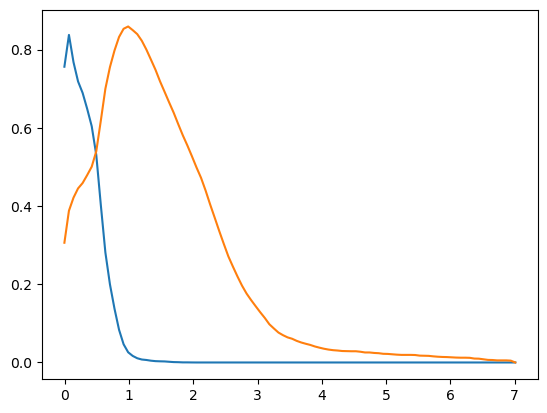

In [10]:
vect_x = np.linspace(X_tr[["redshift"]].min()[0], X_tr[["redshift"]].max()[0], 100)

res_0 = frontiere(X_tr,y_tr, 0, 5, 100)
res_2 = frontiere(X_tr,y_tr, 2, 5, 100)

plt.plot(vect_x, res_0)
plt.plot(vect_x, res_2)

#On prend les seuils qui maximisent la f1 
seuil_0 = vect_x[np.where(res_0==res_0.max())[0][0]]
seuil_2 = vect_x[np.where(res_2==res_2.max())[0][0]]

In [11]:
def predict(val0,val2, X_te): 
    pred = np.ones(X_te.shape[0])
    index_0 = np.where(X_te["redshift"]>val0)[0]
    index_2 = np.where(X_te["redshift"]>val2)[0]
    pred[index_0] = int(0)
    pred[index_2] = int(2)
    return pred.reshape(-1,1)

In [12]:
from sklearn.preprocessing import LabelEncoder

new_pred = pd.DataFrame(predict(seuil_0,seuil_2, X_te))

def Label_Encode(y_tr, new_pred): 
    le = LabelEncoder()
    le.fit(y_tr)
    new_pred = le.transform(new_pred)
    return new_pred

/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [13]:
from sklearn.metrics import confusion_matrix

c_m = confusion_matrix(y_te.to_numpy(), new_pred) / confusion_matrix(y_te.to_numpy(), new_pred).sum()
print("Matrice confusion: ")
print(c_m)
print("")
taux_mal_classes = c_m[0,1:2] + c_m[1,0] + c_m[1,2] + c_m[2,0:1] + c_m[2,0:1]
print("taux_mal_classes: ", taux_mal_classes)
print("")
print("f1_score: ", f1_score(y_te.to_numpy(), new_pred,average="weighted"))

Matrice confusion: 
[[5.67099316e-01 3.58674238e-02 1.06617221e-02]
 [0.00000000e+00 2.10105458e-01 0.00000000e+00]
 [3.52879824e-02 5.79441418e-05 1.40920153e-01]]

taux_mal_classes:  [0.10644339]

f1_score:  0.9174295068999387


Ready for submission: 

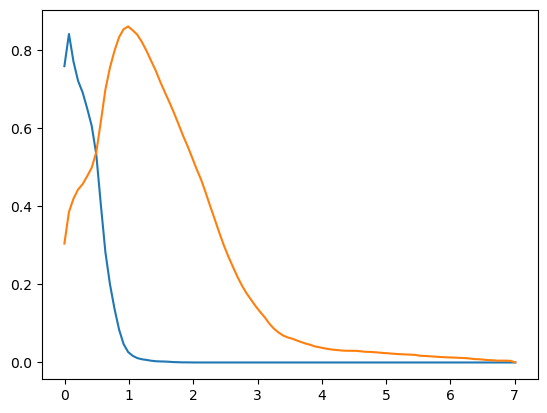

In [14]:
def choix_seuils(X,y,folds,nb_seuils): 
    vect_x = np.linspace(X[["redshift"]].min()[0], X[["redshift"]].max()[0], nb_seuils)
    res_0 = frontiere(X,y, 0, folds, nb_seuils)
    res_2 = frontiere(X,y, 2, folds, nb_seuils)
    plt.plot(vect_x, res_0)
    plt.plot(vect_x, res_2)
    #On prend les seuils qui maximisent la f1 
    seuil_0 = vect_x[np.where(res_0==res_0.max())[0][0]]
    seuil_2 = vect_x[np.where(res_2==res_2.max())[0][0]]
    return seuil_0, seuil_2

In [34]:
new_pred = pd.DataFrame(predict(seuil_0,seuil_2, X_test))

le = LabelEncoder()
le.fit(y)
new_pred = le.transform(new_pred)

/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/DataChallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [38]:
from fcts.general import *